# 0-) IMPORTS

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers             import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1-) DATA ANALYSIS

In [2]:
(X_train,_),(X_test,_) = fashion_mnist.load_data()

In [3]:
#Normalization
X_train = X_train.astype("float32")/255.0
X_test  = X_test.astype("float32")/255.0

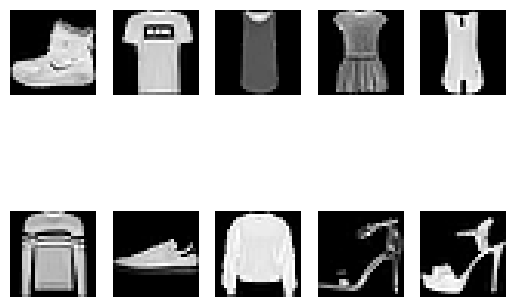

In [4]:
#Visualization
plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i],cmap="gray")
    plt.axis("off")
plt.show()

In [5]:
print(X_train.shape)
print(X_test.shape)
print(len(X_train))
print(len(X_test))

(60000, 28, 28)
(10000, 28, 28)
60000
10000


In [6]:
#Flatten to vector
X_train = X_train.reshape((len(X_train),np.prod(X_train.shape[1:])))
X_test  = X_test.reshape((len(X_test),np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)
print(len(X_train))
print(len(X_test))

(60000, 784)
(10000, 784)
60000
10000


# 2-) MODELLING

## A-) ENCODER AND DECODER

### a-) Autoencoder Parameters

In [7]:
input_dim    = X_train.shape[1] #784
encoding_dim = 64 # Latent size

### b-) Encoder Layer And Decoder Layer

In [11]:
#encoder
input_image = Input(shape=(input_dim,)) #784
encoded     = Dense(512, activation="relu")(input_image)
encoded     = Dense(256, activation="relu")(encoded)
encoded     = Dense(128, activation="relu")(encoded)
encoded     = Dense(encoding_dim, activation="relu")(encoded) #Latent space

#decoder
decoded     = Dense(128, activation="relu")(encoded)
decoded     = Dense(256, activation="relu")(decoded)
decoded     = Dense(512, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)# 784

#Autoencoder = Encoder+Decoder
autoencoder = Model(input_image,decoded)

#Compile
autoencoder.compile(optimizer = Adam(),
                    loss      = "binary_crossentropy")

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 256)               3302

## C-) Model Training

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss",         # Metric to monitor
    patience=10,                 # Number of epochs with no improvement after which training will be stopped
    verbose=1,                  # Verbosity mode, 1 will print messages when stopping
    mode="min",                 # We want to stop when the monitored metric has stopped decreasing
    restore_best_weights=True)  # Restores model weights from the epoch with the best value of the monitored metric

In [13]:
history = autoencoder.fit(x=X_train,
                          y=X_train,
                          epochs=1000,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(X_test,
                                           X_test),
                          verbose=1,
                          callbacks=[early_stopping])

Epoch 1/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.3186 - val_loss: 0.2988
Epoch 2/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2895 - val_loss: 0.2890
Epoch 3/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2829 - val_loss: 0.2841
Epoch 4/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2791 - val_loss: 0.2809
Epoch 5/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2765 - val_loss: 0.2778
Epoch 6/1000
938/938 [==============================] - 4s 5ms/step - loss: 0.2746 - val_loss: 0.2763
Epoch 7/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2734 - val_loss: 0.2758
Epoch 8/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2722 - val_loss: 0.2742
Epoch 9/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.2713 - val_loss: 0.2751
Epoch 10/1000
938/938 [==============================] - 5s 5ms/step - loss: 0.270

# 3-) TESTING

In [16]:
for layer in autoencoder.layers:
    print(layer)

In [19]:
# seperate model as encoder and decoder

#Encoder
encoder = Model(input_image, encoded)

#Decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-4](encoded_input)
decoder_layer2 = autoencoder.layers[-3](decoder_layer1)
decoder_layer3 = autoencoder.layers[-2](decoder_layer2)
decoder_output = autoencoder.layers[-1](decoder_layer3)

decoder = Model(encoded_input, decoder_output)

In [21]:
#compress and reconstruct
encoded_images = encoder.predict(X_test) #Compress to latent
decoded_images = decoder.predict(encoded_images) #Reconstruct from latent

313/313 [==============================] - 0s 939us/step


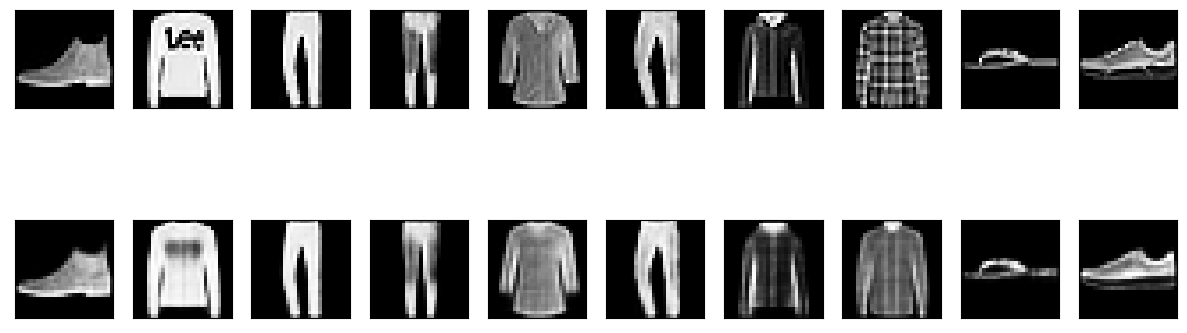

In [23]:
#visualize
n = 10

plt.figure(figsize=(15,5))
for i in range(n):
    #original image
    ax = plt.subplot(2,n,i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #Decoded image
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_images[i].reshape(28,28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
#peak-snr
def calculate_psnr(original, reconstructed):
    mse = np.mean((original-reconstructed)**2)
    if mse == 0:
        return float("inf") #if exact same psnr=infinity
    max_pixel =1.0
    psnr = 20*np.log10(max_pixel/np.sqrt(mse))
    return psnr

In [27]:
psnr_score = []

for i in range(100): #for 100 images
    original_img = X_test[i]
    reconstructed_img = decoded_images[i]
    score = calculate_psnr(original_img,reconstructed_img)
    psnr_score.append(score)

In [30]:
average_psnr = np.mean(psnr_score)
print(f"Average PSNR: {average_psnr}")

Average PSNR: 23.736482695846625
